# Variational Autoencoders

<img src="VAE.JPG">

## Download MNIST and load it

In [1]:
# import os
# import random
# import numpy as np
# import tensorflow as tf
# import matplotlib.pyplot as plt
# %matplotlib inline

# import sys
# import shutil
# from six.moves import urllib
# import gzip
# import cPickle
# import imageio


# SOURCE_URL = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
# FILENAME = SOURCE_URL.split('/')[-1]
# DATA_DIR = './datasets'


# def img_tile(imgs, aspect_ratio=1.0, tile_shape=None, border=1,
#              border_color=0):
#     imgs = np.array(imgs)
#     if imgs.ndim != 3 and imgs.ndim != 4:
#         raise ValueError('imgs has wrong number of dimensions.')
#     n_imgs = imgs.shape[0]

#     # Grid shape
#     img_shape = np.array(imgs.shape[1:3])
#     if tile_shape is None:
#         img_aspect_ratio = img_shape[1] / float(img_shape[0])
#         aspect_ratio *= img_aspect_ratio
#         tile_height = int(np.ceil(np.sqrt(n_imgs * aspect_ratio)))
#         tile_width = int(np.ceil(np.sqrt(n_imgs / aspect_ratio)))
#         grid_shape = np.array((tile_height, tile_width))
#     else:
#         assert len(tile_shape) == 2
#         grid_shape = np.array(tile_shape)

#     # Tile image shape
#     tile_img_shape = np.array(imgs.shape[1:])
#     tile_img_shape[:2] = (img_shape[:2] + border) * grid_shape[:2] - border

#     # Assemble tile image
#     tile_img = np.empty(tile_img_shape)
#     tile_img[:] = border_color
#     for i in range(grid_shape[0]):
#         for j in range(grid_shape[1]):
#             img_idx = j + i * grid_shape[1]
#             if img_idx >= n_imgs:
#                 # No more images - stop filling out the grid.
#                 break
#             img = imgs[img_idx]
#             yoff = (img_shape[0] + border) * i
#             xoff = (img_shape[1] + border) * j
#             tile_img[yoff:yoff + img_shape[0], xoff:xoff + img_shape[1], ...] = img

#     return tile_img


# def plot_network_output(data, reconst_data, generated, step):
#     num = 8
    
#     fig, ax = plt.subplots(nrows=3, ncols=num, figsize=(18, 6))
#     for i in xrange(num):
#         ax[(0, i)].imshow(np.squeeze(generated[i]), cmap=plt.cm.gray)
#         ax[(1, i)].imshow(np.squeeze(data[i]), cmap=plt.cm.gray)
#         ax[(2, i)].imshow(np.squeeze(reconst_data[i]), cmap=plt.cm.gray)
#         ax[(0, i)].axis('off')
#         ax[(1, i)].axis('off')
#         ax[(2, i)].axis('off')

#     fig.suptitle('Top: generated | Middle: data | Bottom: recunstructed')
# #     plt.show()
#     plt.savefig(IMAGE_DIR + '/{}.png'.format(str(step).zfill(6)))
#     plt.close()


# def maybe_download(data_dir):
#     filepath = os.path.join(data_dir, FILENAME)
#     if not os.path.exists(data_dir):
#         os.makedirs(data_dir)
#     if not os.path.isfile(filepath):
#         def _progress(count, block_size, total_size):
#             sys.stdout.write('\r>> Downloading {} {:.1f} %'.format(
#                 FILENAME, float(count * block_size) / float(total_size) * 100.0))
#             sys.stdout.flush()
#         filepath, _ = urllib.request.urlretrieve(SOURCE_URL, filepath, _progress)
#         print()
#         statinfo = os.stat(filepath)
#         print('Successfully donloaded', FILENAME, statinfo.st_size, 'bytes.')


# def load(data_dir, subset='train'):
#     maybe_download(data_dir)
#     filepath = os.path.join(data_dir, FILENAME)

#     f = gzip.open(filepath, 'rb')
#     train_set, valid_set, test_set = cPickle.load(f)
#     f.close()

#     if subset == 'train':
#         trainx, trainy = train_set
#         trainx = trainx.astype(np.float32).reshape(trainx.shape[0], 28, 28)
#         trainy = trainy.astype(np.uint8)
#         return trainx, trainy
#     elif subset == 'test':
#         testx, testy = test_set
#         testx = testx.astype(np.float32).reshape(testx.shape[0], 28, 28)
#         testy = testy.astype(np.uint8)
#         return testx, testy
#     elif subset == 'valid':
#         validx, validy = valid_set
#         validx = validx.astype(np.float32).reshape(validx.shape[0], 28, 28)
#         validy = validy.astype(np.uint8)
#         return validx, validy
#     else:
#         raise NotImplementedError('subset should be train or valid or test')

# # Load data
# train_data, train_label = load(DATA_DIR, 'train')
# valid_data, valid_label = load(DATA_DIR, 'valid')
# test_data, test_label = load(DATA_DIR, 'test')

# # concatenate train and valid data as train data
# train_data = np.concatenate((train_data, valid_data))
# train_label = np.concatenate((train_label, valid_label))

In [2]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import shutil

from keras.datasets import mnist
(train_data, train_label), (test_data, test_label) = mnist.load_data()
train_data = train_data / 255.
test_data = test_data / 255.

def img_tile(imgs, aspect_ratio=1.0, tile_shape=None, border=1,
             border_color=0):
    imgs = np.array(imgs)
    if imgs.ndim != 3 and imgs.ndim != 4:
        raise ValueError('imgs has wrong number of dimensions.')
    n_imgs = imgs.shape[0]

    # Grid shape
    img_shape = np.array(imgs.shape[1:3])
    if tile_shape is None:
        img_aspect_ratio = img_shape[1] / float(img_shape[0])
        aspect_ratio *= img_aspect_ratio
        tile_height = int(np.ceil(np.sqrt(n_imgs * aspect_ratio)))
        tile_width = int(np.ceil(np.sqrt(n_imgs / aspect_ratio)))
        grid_shape = np.array((tile_height, tile_width))
    else:
        assert len(tile_shape) == 2
        grid_shape = np.array(tile_shape)

    # Tile image shape
    tile_img_shape = np.array(imgs.shape[1:])
    tile_img_shape[:2] = (img_shape[:2] + border) * grid_shape[:2] - border

    # Assemble tile image
    tile_img = np.empty(tile_img_shape)
    tile_img[:] = border_color
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            img_idx = j + i * grid_shape[1]
            if img_idx >= n_imgs:
                # No more images - stop filling out the grid.
                break
            img = imgs[img_idx]
            yoff = (img_shape[0] + border) * i
            xoff = (img_shape[1] + border) * j
            tile_img[yoff:yoff + img_shape[0], xoff:xoff + img_shape[1], ...] = img

    return tile_img


def plot_network_output(data, reconst_data, generated, step):
    num = 8
    
    fig, ax = plt.subplots(nrows=3, ncols=num, figsize=(18, 6))
    for i in range(num):
        ax[(0, i)].imshow(np.squeeze(generated[i]), cmap=plt.cm.gray)
        ax[(1, i)].imshow(np.squeeze(data[i]), cmap=plt.cm.gray)
        ax[(2, i)].imshow(np.squeeze(reconst_data[i]), cmap=plt.cm.gray)
        ax[(0, i)].axis('off')
        ax[(1, i)].axis('off')
        ax[(2, i)].axis('off')

    fig.suptitle('Top: generated | Middle: data | Bottom: recunstructed')
#     plt.show()
    plt.savefig(IMAGE_DIR + '/{}.png'.format(str(step).zfill(6)))
    plt.close()

Using TensorFlow backend.


## show MNIST

In [3]:
# size of MNIST
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


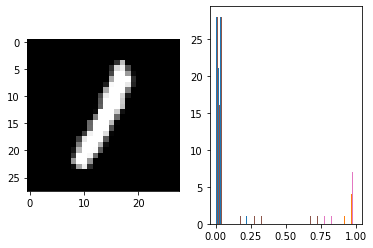

In [4]:
# show data
idx = np.random.randint(0, train_data.shape[0])
_, (ax1, ax2) = plt.subplots(1, 2)
sample_data = train_data[idx]
ax1.imshow(sample_data, 'gray');
ax2.hist(sample_data, bins=20, range=[0, 1]);

## Delete summary folder and make it

In [5]:
SUMMARY_DIR = './vae_summary'
TRAIN_DIR = SUMMARY_DIR + '/train'
TEST_DIR = SUMMARY_DIR + '/test'
IMAGE_DIR = SUMMARY_DIR + '/image'

if os.path.exists(SUMMARY_DIR):
    shutil.rmtree(SUMMARY_DIR)
if not os.path.exists(SUMMARY_DIR):
    os.makedirs(SUMMARY_DIR)
    os.makedirs(TRAIN_DIR)
    os.makedirs(TEST_DIR)
    os.makedirs(IMAGE_DIR)

## Define tensorflow graph

In [6]:
def fully_connected(inputs, out_channel, name='fc'):
    """
    very simple fully connected layer function

    Args:
        inputs: a batch of input tensor [batch_size, n]
                where n is the number of feature dimension
        out_channel: output channel dimension

    Returns:
        inputs * weights + biases [batch_size, out_channel]
    """
    # in_channel: input channel dimension
    # w_shape: shape of weight matrix
    # b_shape: shape of bias vector
    in_channel = inputs.get_shape().as_list()[1]
    w_shape = [in_channel, out_channel]
    b_shape = [out_channel]

    # Define weight matrix variable, bias vector variable
    with tf.variable_scope(name):
        # To share the variables you have to use
        # a function 'tf.get_variable' instead of 'tf.Variable'
        weights = tf.get_variable('weights', shape=w_shape,
                                  initializer=tf.truncated_normal_initializer(stddev=0.02))
        biases = tf.get_variable('biases', shape=b_shape,
                                 initializer=tf.constant_initializer(0.0))

        fc = tf.matmul(inputs, weights)
        fc = tf.nn.bias_add(fc, biases)

        return fc


def encoder(x, z_dim):
    """
    build the encoder

    Args:
        x: a batch of input to the network [batch_size, 28, 28, 1]
        z_dim: dimension of the latent variable z

    returns:
        z_mean: mean of the latent variable [batch_size, n_latent]
        z_log_sigma_sq : log sigma squre of the latent variable [batch_size, n_latent]
    """
    with tf.variable_scope('encoder') as scope:

        # Vectorize the input x
        # Fully connected layer with 256 output units and 'fc1' as its name
        # Apply non-linearity function 'relu'
        # Fully connected layer with 256 output units and 'fc2' as its name
        # Apply non-linearity function 'relu'
        # Fully connected layer with z_dim * 2 units and 'fc3' as its name
        # split the final tensor into mean and the log sigma square of the latent variable
        # Return the final tensors
        net = tf.reshape(x, [x.get_shape().as_list()[0], -1])
        net = fully_connected(net, 256, name='fc1')
        net = tf.nn.relu(net)
        net = fully_connected(net, 256, name='fc2')
        net = tf.nn.relu(net)
        net = fully_connected(net, z_dim * 2, name='fc3')
        z_mean, z_log_sigma_sq = tf.split(net, num_or_size_splits=2, axis=1)
        return z_mean, z_log_sigma_sq


def decoder(z, reuse=False):
    """
    build the decoder

    Args:
        z: a batch of input to the network [batch_size, n_latent]

    Returns:
        net: output of the generator [batch_size, 28, 28, 1]
    """
    with tf.variable_scope('generator') as scope:
        if reuse:
            scope.reuse_variables()

        # Fully connected layer with 256 output units and 'fc1' as its name
        # Apply non-linearity function 'relu'
        # Fully connected layer with 256 output units and 'fc2' as its name
        # Apply non-linearity function 'relu'
        # Fully connected layer with 784 output units and 'fc3' as its name
        # Apply non-linearity function 'sigmoid'
        # Reshape final output to be a proper image file [28, 28, 1]
        # Return the final tensor
        net = fully_connected(z, 256, name='fc1')
        net = tf.nn.relu(net)
        net = fully_connected(net, 256, name='fc2')
        net = tf.nn.relu(net)
        net = fully_connected(net, 784, name='fc3')
        net = tf.nn.sigmoid(net)
        net = tf.reshape(net, [z.get_shape().as_list()[0], 28, 28, 1])
        return net

### reconstrunction_loss = $$-\Sigma_{i=1}^{D} x_{i}log y_{i} + (1-x_{i})log(1-y_{i}))$$
### KL_loss = $$-\frac{1}{2}\Sigma_{j=1}^{J}(1+log \sigma_{j}^2 - \mu_{j}^2 -\sigma_{j}^2)$$
    
### Loss = reconstruction_loss + KL_loss

In [7]:
def get_loss(x, reconst_x, z_mean, z_log_sigma_sq, eps=1e-8):
    """
    get loss of GAN

    Args:
        x: input tensor [batch_size, 28, 28, 1]
        reconst_x: reconstructed tensor [batch_size, 28, 28, 1]
        z_mean: mean of the latent variable [batch_size, z_dim]
        z_log_sigma_sq: log sigma square of the latent variable [batch_size, z_dim]

    Returns:
        reconst_loss: reconstruction loss
        kl_loss: regularization loss
    """
    reconst_loss = -tf.reduce_mean(tf.reduce_sum(x * tf.log(reconst_x + eps) + (1.0 - x) * tf.log(1.0 - reconst_x + eps), [1, 2, 3]))
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_sigma_sq - tf.square(z_mean) - tf.exp(z_log_sigma_sq), 1))

    return reconst_loss, kl_loss


def get_next_batch(data, label, batch_size):
    """
    get 'batch_size' amount of data and label randomly

    Args:
        data: data
        label: label
        batch_size: # of data to get

    Returns:
        batch_data: data of 'batch_size'
        batch_label: coresponding label of batch_data
    """
    n_data = data.shape[0]
    random_idx = random.sample(range(1, n_data), batch_size)

    batch_data = data[random_idx]
    batch_label = label[random_idx]
    return batch_data, batch_label

# Set hyperparameters
batch_size = 100
z_dim = 2
max_step = 20000
lr = 0.001
beta1 = 0.9

# expand the data to be 3 dimensional data.
train_data = np.expand_dims(train_data, 3)
test_data = np.expand_dims(test_data, 3)

############################# Build the model #############################
# Define image tensor x placeholder
x = tf.placeholder(tf.float32, [batch_size, 28, 28, 1], name='input_x')
# Define latent tensor z placeholder
z = tf.placeholder(tf.float32, [batch_size, z_dim], name='input_z')

# Defin normal distribution (mu=0, sigma=1)
try:
    # for tensorflow version >= r.1.0 
    normal_dist = tf.contrib.distributions.Normal(loc=0., scale=1.)
except:
    # for tensorflow version < r.1.0
    normal_dist = tf.contrib.distributions.Normal(mu=0., sigma=1.)

# Build encoder
z_mean, z_log_sigma_sq = encoder(x, z_dim)
# Get epsilon to recover encoded_z
eps = normal_dist.sample([batch_size, z_dim])
# Get encoded_z using z_mean, z_log_sigma_sq, eps
encoded_z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))
# Build decoder with encoded_z which outputs reconst_x
# reconst_x is reconstruction of the input data x
reconst_x = decoder(encoded_z, False)
# Build decoder with placeholder z which outputs sample_x
# sample_x is generated data from VAE
sample_x = decoder(z, True)

# Get reconst_loss and kl_loss
reconst_loss, kl_loss = get_loss(x, reconst_x, z_mean, z_log_sigma_sq)
loss = reconst_loss + kl_loss

# Make optimization op
opt = tf.train.AdamOptimizer(lr, beta1=beta1)

# Make train op for each network
train = opt.minimize(loss)

# Make initialization op
init = tf.global_variables_initializer()

# Add summary and make op to add summary data to event log
tf.summary.scalar('KL_loss', kl_loss)
tf.summary.scalar('Reconstruction_loss', reconst_loss)
tf.summary.scalar('Total_loss', kl_loss + reconst_loss)
merged = tf.summary.merge_all()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Train VAE

Training data


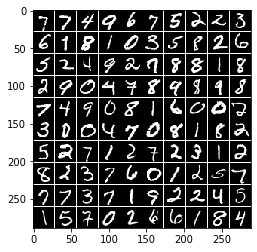

0 steps |  total_loss: 543.4327, KL_loss: 0.0000, reconst_loss: 543.4327


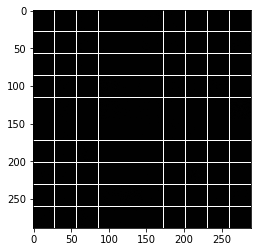

200 steps |  total_loss: 196.7111, KL_loss: 1.9438, reconst_loss: 194.7674


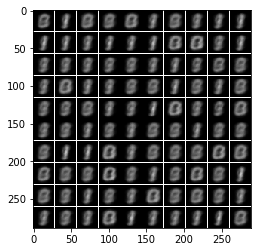

400 steps |  total_loss: 191.2054, KL_loss: 2.0283, reconst_loss: 189.1771


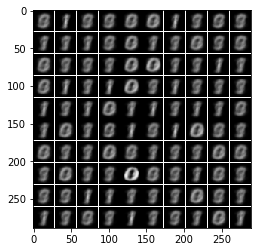

600 steps |  total_loss: 187.0537, KL_loss: 2.4145, reconst_loss: 184.6392


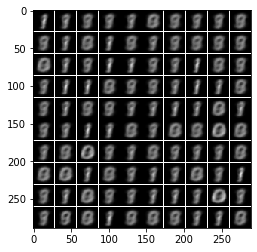

800 steps |  total_loss: 184.1965, KL_loss: 4.2634, reconst_loss: 179.9332


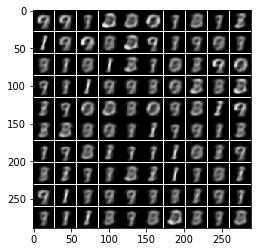

1000 steps |  total_loss: 170.8513, KL_loss: 4.2673, reconst_loss: 166.5840


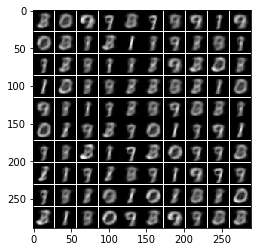

1200 steps |  total_loss: 168.0021, KL_loss: 4.8944, reconst_loss: 163.1077


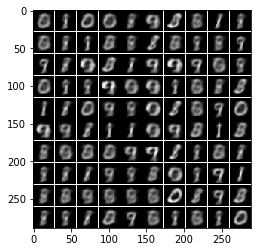

1400 steps |  total_loss: 170.5687, KL_loss: 4.7394, reconst_loss: 165.8293


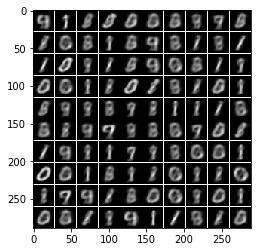

1600 steps |  total_loss: 159.0882, KL_loss: 4.7047, reconst_loss: 154.3835


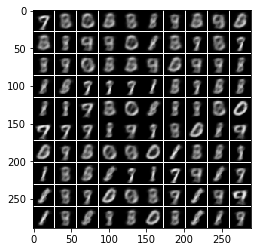

1800 steps |  total_loss: 159.3691, KL_loss: 4.7324, reconst_loss: 154.6367


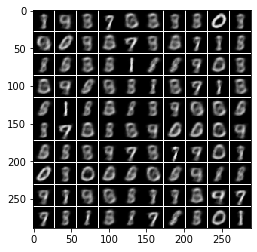

2000 steps |  total_loss: 163.2913, KL_loss: 5.3868, reconst_loss: 157.9045


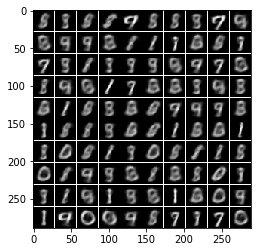

2200 steps |  total_loss: 161.0052, KL_loss: 4.8942, reconst_loss: 156.1110


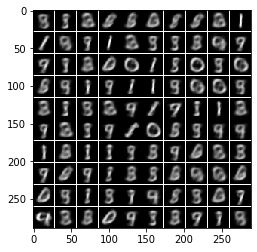

2400 steps |  total_loss: 158.9625, KL_loss: 5.1103, reconst_loss: 153.8523


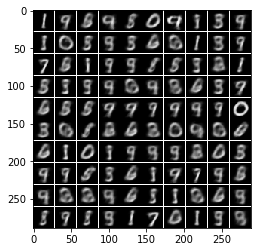

2600 steps |  total_loss: 158.1797, KL_loss: 5.1845, reconst_loss: 152.9952


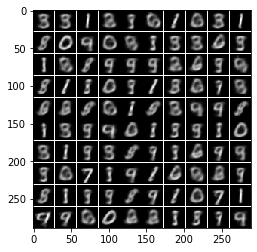

2800 steps |  total_loss: 153.5711, KL_loss: 5.2376, reconst_loss: 148.3335


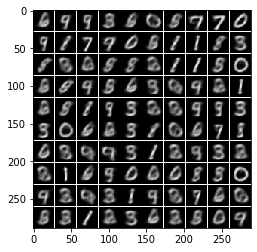

3000 steps |  total_loss: 160.9403, KL_loss: 5.5601, reconst_loss: 155.3802


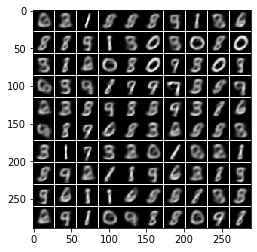

3200 steps |  total_loss: 163.2846, KL_loss: 5.2110, reconst_loss: 158.0737


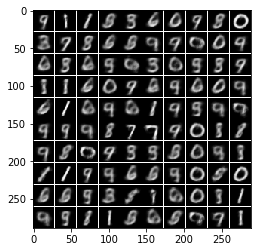

3400 steps |  total_loss: 146.2778, KL_loss: 5.8625, reconst_loss: 140.4153


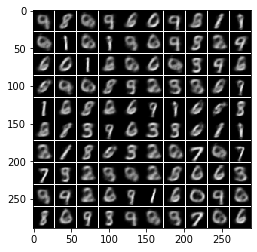

3600 steps |  total_loss: 163.4738, KL_loss: 5.4639, reconst_loss: 158.0098


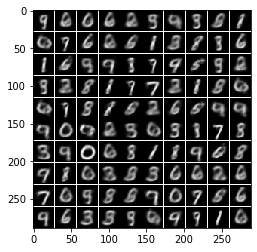

3800 steps |  total_loss: 158.9180, KL_loss: 5.5628, reconst_loss: 153.3552


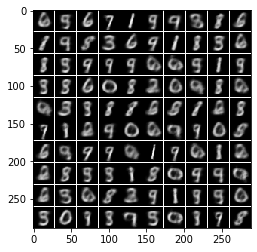

4000 steps |  total_loss: 152.7471, KL_loss: 5.4045, reconst_loss: 147.3426


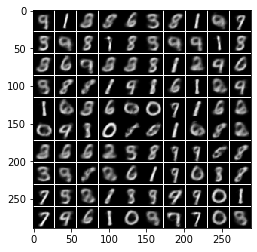

4200 steps |  total_loss: 157.9137, KL_loss: 5.4587, reconst_loss: 152.4550


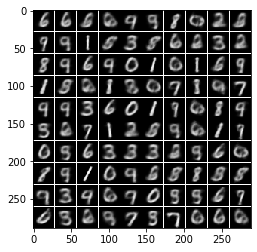

4400 steps |  total_loss: 156.6203, KL_loss: 5.9942, reconst_loss: 150.6261


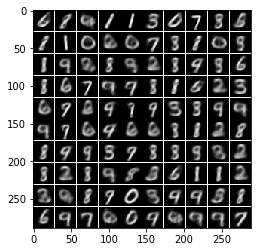

4600 steps |  total_loss: 156.5432, KL_loss: 6.2543, reconst_loss: 150.2889


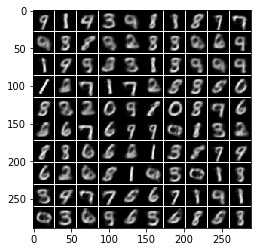

4800 steps |  total_loss: 157.2884, KL_loss: 5.6968, reconst_loss: 151.5916


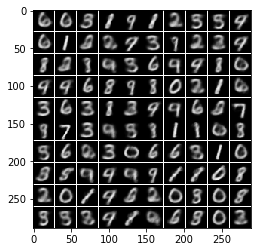

5000 steps |  total_loss: 141.1879, KL_loss: 5.8237, reconst_loss: 135.3641


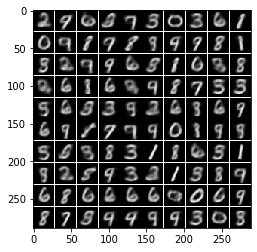

5200 steps |  total_loss: 149.7870, KL_loss: 5.8627, reconst_loss: 143.9243


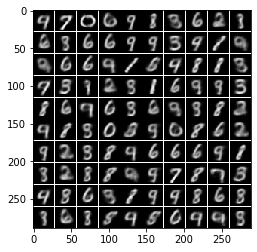

5400 steps |  total_loss: 153.3506, KL_loss: 6.0973, reconst_loss: 147.2533


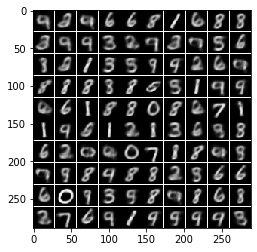

5600 steps |  total_loss: 146.6399, KL_loss: 6.0588, reconst_loss: 140.5811


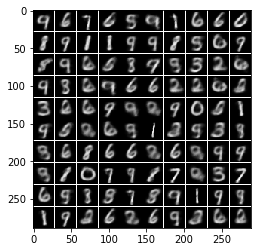

5800 steps |  total_loss: 150.1939, KL_loss: 6.2408, reconst_loss: 143.9531


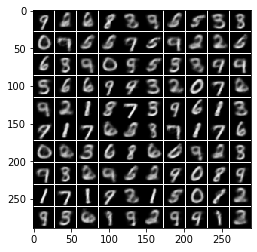

6000 steps |  total_loss: 150.9904, KL_loss: 6.0039, reconst_loss: 144.9866


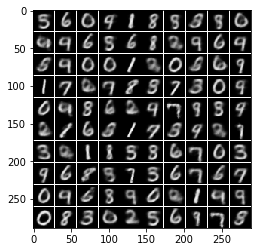

6200 steps |  total_loss: 143.2666, KL_loss: 6.3066, reconst_loss: 136.9601


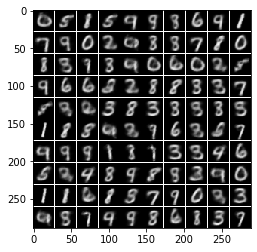

6400 steps |  total_loss: 147.0064, KL_loss: 6.1466, reconst_loss: 140.8597


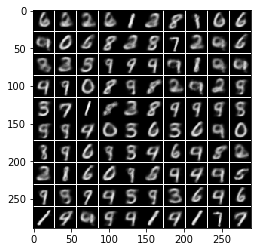

6600 steps |  total_loss: 154.8277, KL_loss: 6.0577, reconst_loss: 148.7700


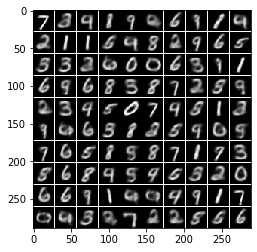

6800 steps |  total_loss: 142.3425, KL_loss: 6.3120, reconst_loss: 136.0305


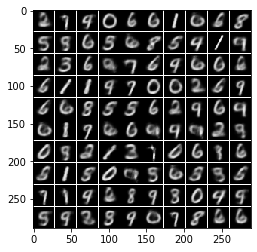

7000 steps |  total_loss: 141.1920, KL_loss: 6.0134, reconst_loss: 135.1786


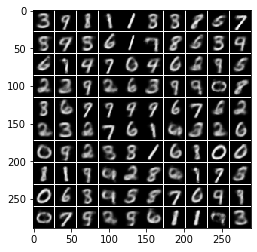

7200 steps |  total_loss: 145.9193, KL_loss: 6.0718, reconst_loss: 139.8475


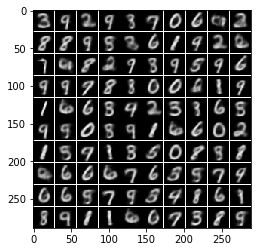

7400 steps |  total_loss: 148.1790, KL_loss: 6.1546, reconst_loss: 142.0244


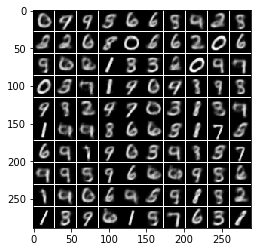

7600 steps |  total_loss: 136.3892, KL_loss: 6.5112, reconst_loss: 129.8779


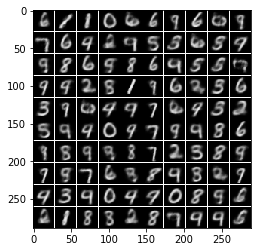

7800 steps |  total_loss: 143.6393, KL_loss: 6.0784, reconst_loss: 137.5609


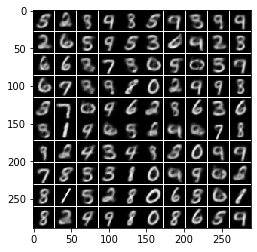

8000 steps |  total_loss: 147.4065, KL_loss: 6.3811, reconst_loss: 141.0254


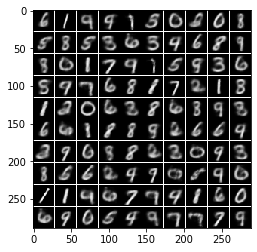

8200 steps |  total_loss: 147.0302, KL_loss: 6.6690, reconst_loss: 140.3611


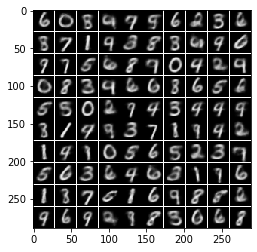

8400 steps |  total_loss: 149.6308, KL_loss: 6.3007, reconst_loss: 143.3300


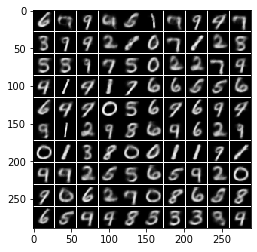

8600 steps |  total_loss: 134.7207, KL_loss: 6.4644, reconst_loss: 128.2563


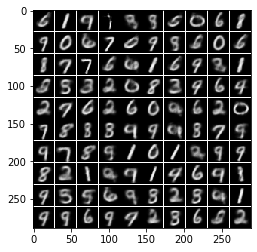

8800 steps |  total_loss: 137.9108, KL_loss: 6.2789, reconst_loss: 131.6319


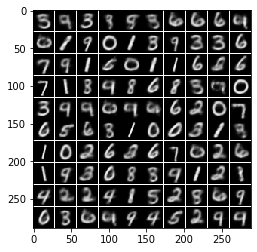

9000 steps |  total_loss: 144.4750, KL_loss: 6.2408, reconst_loss: 138.2342


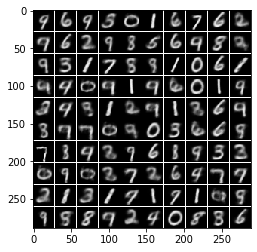

9200 steps |  total_loss: 142.8814, KL_loss: 6.1795, reconst_loss: 136.7020


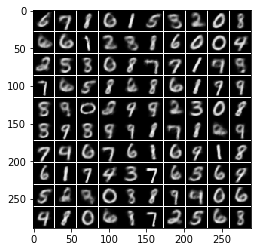

9400 steps |  total_loss: 146.8407, KL_loss: 6.2470, reconst_loss: 140.5937


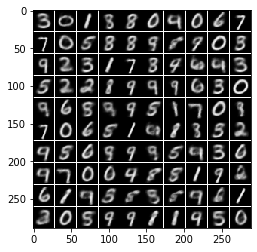

9600 steps |  total_loss: 135.3877, KL_loss: 6.4937, reconst_loss: 128.8940


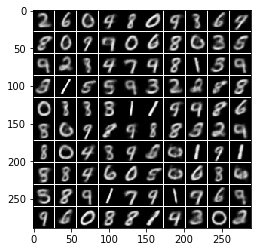

9800 steps |  total_loss: 142.3118, KL_loss: 6.4318, reconst_loss: 135.8800


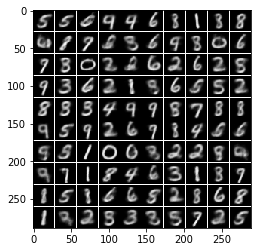

10000 steps |  total_loss: 138.5656, KL_loss: 6.4563, reconst_loss: 132.1093


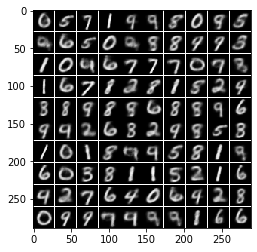

10200 steps |  total_loss: 133.1045, KL_loss: 6.4541, reconst_loss: 126.6504


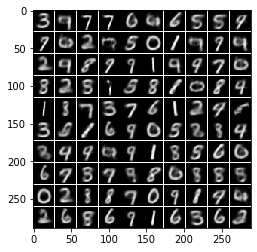

10400 steps |  total_loss: 141.8352, KL_loss: 6.5420, reconst_loss: 135.2932


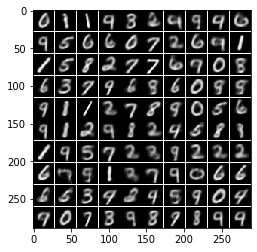

10600 steps |  total_loss: 139.4766, KL_loss: 6.3487, reconst_loss: 133.1279


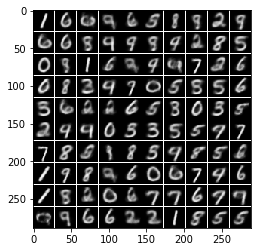

10800 steps |  total_loss: 144.3033, KL_loss: 6.6208, reconst_loss: 137.6825


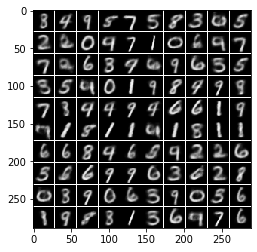

11000 steps |  total_loss: 139.3282, KL_loss: 6.4933, reconst_loss: 132.8350


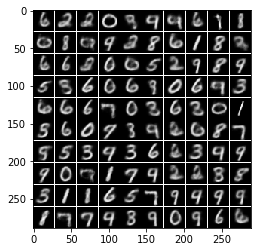

11200 steps |  total_loss: 139.7766, KL_loss: 6.5943, reconst_loss: 133.1824


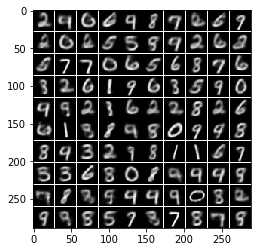

11400 steps |  total_loss: 144.5588, KL_loss: 6.2337, reconst_loss: 138.3251


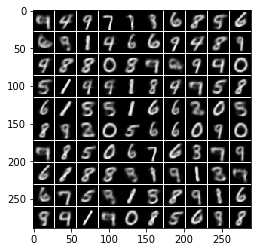

11600 steps |  total_loss: 147.1280, KL_loss: 6.3194, reconst_loss: 140.8086


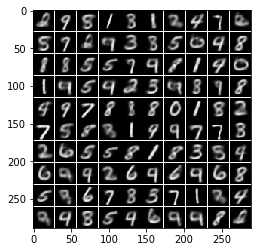

11800 steps |  total_loss: 143.2062, KL_loss: 6.5929, reconst_loss: 136.6133


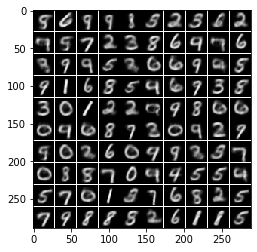

12000 steps |  total_loss: 147.6542, KL_loss: 6.4633, reconst_loss: 141.1909


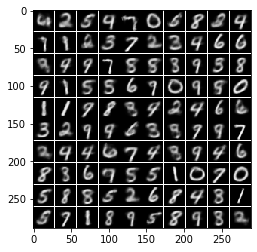

12200 steps |  total_loss: 141.8583, KL_loss: 6.5472, reconst_loss: 135.3110


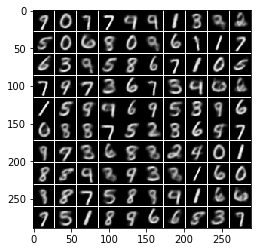

12400 steps |  total_loss: 152.6403, KL_loss: 6.3766, reconst_loss: 146.2637


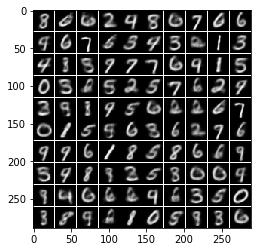

12600 steps |  total_loss: 138.0473, KL_loss: 6.5576, reconst_loss: 131.4898


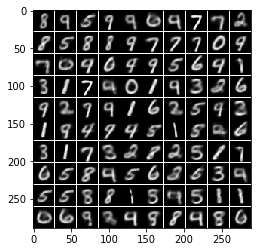

12800 steps |  total_loss: 130.4606, KL_loss: 6.4962, reconst_loss: 123.9644


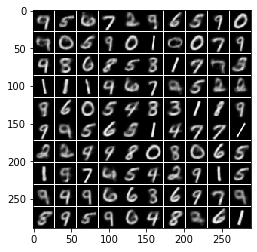

13000 steps |  total_loss: 152.1522, KL_loss: 6.4323, reconst_loss: 145.7199


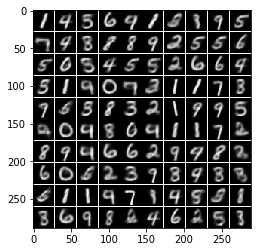

13200 steps |  total_loss: 139.2437, KL_loss: 6.7182, reconst_loss: 132.5255


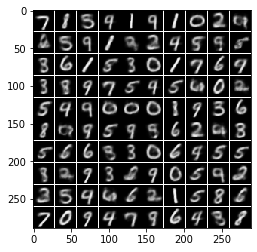

13400 steps |  total_loss: 137.9823, KL_loss: 6.4872, reconst_loss: 131.4951


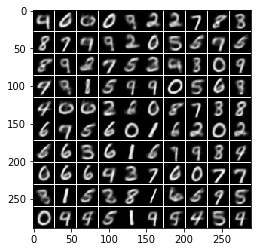

13600 steps |  total_loss: 140.8127, KL_loss: 6.3925, reconst_loss: 134.4202


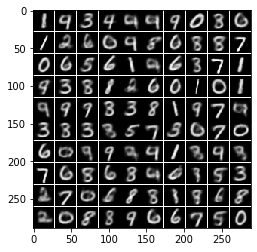

13800 steps |  total_loss: 139.3309, KL_loss: 6.4182, reconst_loss: 132.9127


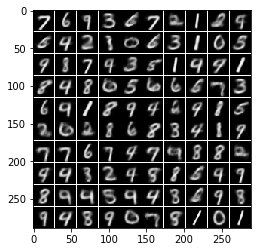

14000 steps |  total_loss: 142.6144, KL_loss: 6.4542, reconst_loss: 136.1603


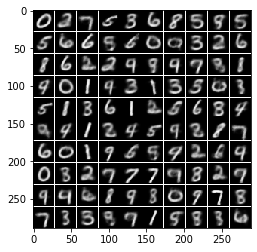

14200 steps |  total_loss: 132.2173, KL_loss: 6.7979, reconst_loss: 125.4194


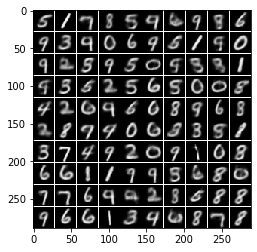

14400 steps |  total_loss: 144.2951, KL_loss: 6.4960, reconst_loss: 137.7990


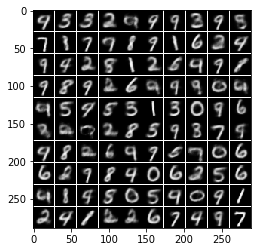

14600 steps |  total_loss: 141.5205, KL_loss: 6.4682, reconst_loss: 135.0523


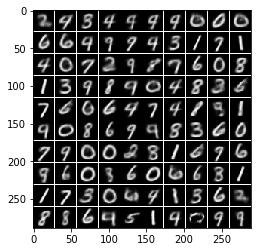

14800 steps |  total_loss: 136.8182, KL_loss: 6.4832, reconst_loss: 130.3350


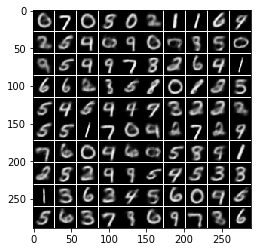

15000 steps |  total_loss: 141.8085, KL_loss: 6.6123, reconst_loss: 135.1962


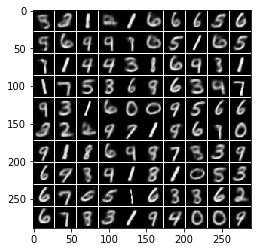

15200 steps |  total_loss: 140.9471, KL_loss: 6.5985, reconst_loss: 134.3485


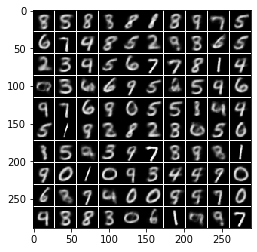

15400 steps |  total_loss: 139.1356, KL_loss: 6.5539, reconst_loss: 132.5817


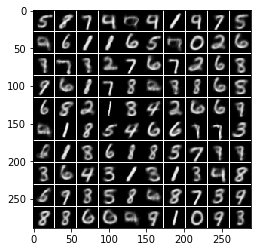

15600 steps |  total_loss: 140.5708, KL_loss: 6.5190, reconst_loss: 134.0518


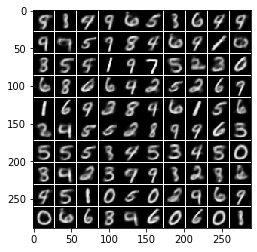

15800 steps |  total_loss: 143.3101, KL_loss: 6.6278, reconst_loss: 136.6823


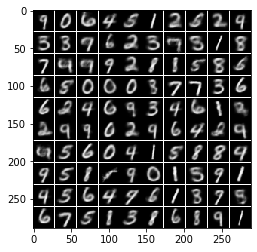

16000 steps |  total_loss: 138.0410, KL_loss: 6.7117, reconst_loss: 131.3292


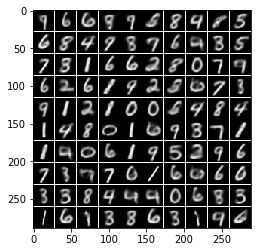

16200 steps |  total_loss: 146.8899, KL_loss: 6.5407, reconst_loss: 140.3492


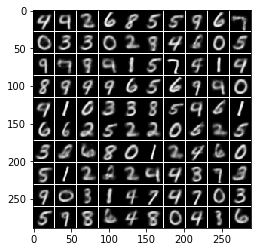

16400 steps |  total_loss: 144.3462, KL_loss: 6.4840, reconst_loss: 137.8622


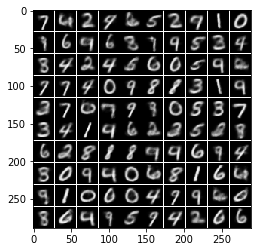

16600 steps |  total_loss: 141.2760, KL_loss: 6.6385, reconst_loss: 134.6375


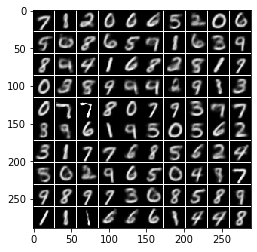

16800 steps |  total_loss: 141.5431, KL_loss: 6.7524, reconst_loss: 134.7906


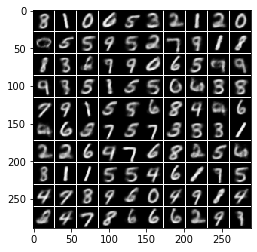

17000 steps |  total_loss: 141.6339, KL_loss: 6.4700, reconst_loss: 135.1639


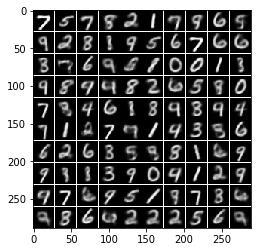

17200 steps |  total_loss: 142.8276, KL_loss: 6.5190, reconst_loss: 136.3086


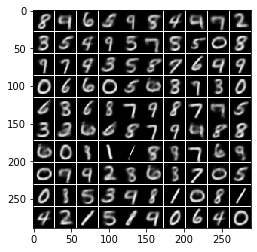

17400 steps |  total_loss: 134.8691, KL_loss: 6.8350, reconst_loss: 128.0341


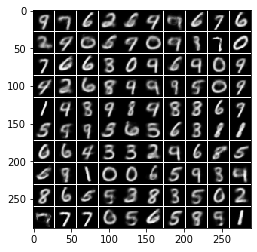

17600 steps |  total_loss: 131.3734, KL_loss: 6.6884, reconst_loss: 124.6850


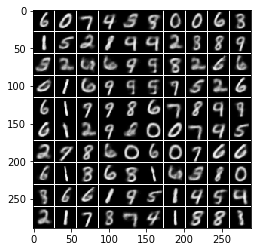

17800 steps |  total_loss: 148.5318, KL_loss: 6.6487, reconst_loss: 141.8831


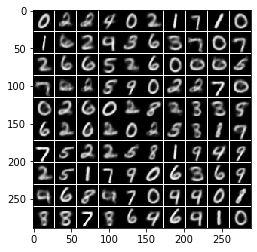

18000 steps |  total_loss: 138.4641, KL_loss: 6.6708, reconst_loss: 131.7932


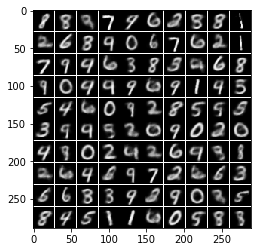

18200 steps |  total_loss: 146.1575, KL_loss: 6.5673, reconst_loss: 139.5902


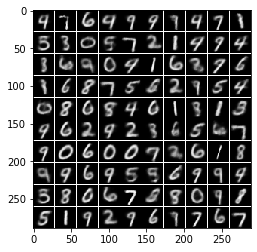

18400 steps |  total_loss: 141.0911, KL_loss: 6.8386, reconst_loss: 134.2525


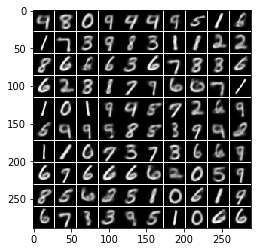

18600 steps |  total_loss: 133.6944, KL_loss: 6.5692, reconst_loss: 127.1251


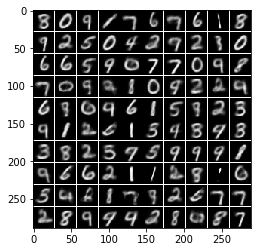

18800 steps |  total_loss: 134.0445, KL_loss: 6.8300, reconst_loss: 127.2145


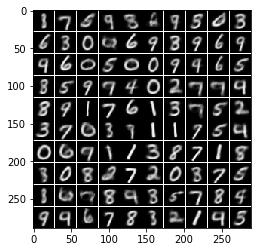

19000 steps |  total_loss: 142.2174, KL_loss: 6.6740, reconst_loss: 135.5434


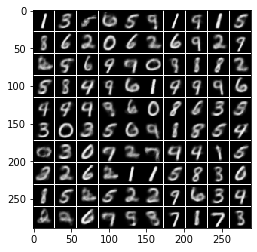

19200 steps |  total_loss: 139.3790, KL_loss: 6.6982, reconst_loss: 132.6807


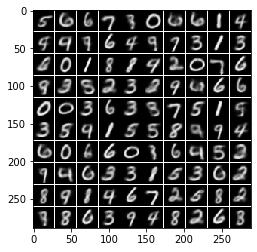

19400 steps |  total_loss: 140.9513, KL_loss: 6.6387, reconst_loss: 134.3125


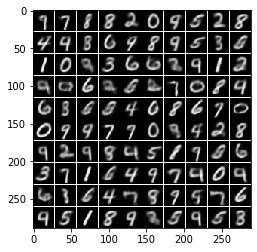

19600 steps |  total_loss: 145.3083, KL_loss: 6.6688, reconst_loss: 138.6395


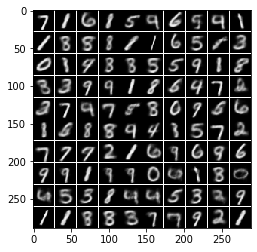

19800 steps |  total_loss: 134.4005, KL_loss: 6.7842, reconst_loss: 127.6163


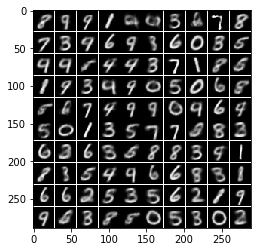

In [8]:
with tf.Session() as sess:
    # Define writer
    train_writer = tf.summary.FileWriter(TRAIN_DIR, sess.graph)
    test_writer = tf.summary.FileWriter(TEST_DIR)
    
    # Initialize variables
    sess.run(init)
    
    # Before train the model, shows train data and save it
    batch_x, batch_y = get_next_batch(train_data, train_label, batch_size)
    train_tiled = img_tile(batch_x, border_color=1.0)
    train_tiled = np.squeeze(train_tiled)
    print("Training data")
    plt.imshow(train_tiled, cmap=plt.cm.gray)
    plt.show()
    plt.imsave(IMAGE_DIR + '/train.png', train_tiled, cmap=plt.cm.gray)

    samples = []
    canvases = []
    # Train the model
    for step in range(max_step):
        batch_x, batch_y = get_next_batch(train_data, train_label, batch_size)
        batch_z = np.random.normal(loc=0., scale=1.0, size=[batch_size, z_dim])
        
        _, reconst_losses, kl_losses = sess.run(
            [train, reconst_loss, kl_loss], feed_dict={x: batch_x, z: batch_z})
        summary = sess.run(merged, feed_dict={x: batch_x, z: batch_z})
        train_writer.add_summary(summary, step)

        # Save generarted data to make gif files
        if step % 50 == 0:
            r_x, s_x = sess.run([reconst_x, sample_x], feed_dict={x: batch_x, z: batch_z})
            sample_tiled = img_tile(s_x, border_color=1.0)
            sample_tiled = np.squeeze(sample_tiled)
            samples.append(sample_tiled)
            
            nx = ny = 20
            x_values = np.linspace(-3, 3, nx)
            y_values = np.linspace(-3, 3, ny)
            canvas = np.empty((28*ny, 28*nx))
            for i, yi in enumerate(x_values):
                for j, xi in enumerate(y_values):
                    z_mu = np.array([[xi, yi]] * batch_size)
                    x_mean = sess.run(sample_x, feed_dict={z: z_mu})
                    canvas[(nx - i - 1) * 28:(nx - i) * 28, j * 28:(j + 1) * 28] = x_mean[0].reshape(28, 28)
            canvases.append(canvas)

        # Log loss and save train data and reconstructed data
        if step % 200 == 0:
            plot_network_output(batch_x, r_x, s_x, step)
            print("{} steps |  total_loss: {:.4f}, KL_loss: {:.4f}, reconst_loss: {:.4f}".format(
                step, kl_losses + reconst_losses, kl_losses, reconst_losses))
            plt.imshow(sample_tiled, cmap=plt.cm.gray)
            plt.show()

In [9]:
import imageio
# Make gif files
imageio.mimsave(SUMMARY_DIR + '/generated.gif', samples)
imageio.mimsave(SUMMARY_DIR + '/canvase.gif', canvases)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0